In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import pathlib
import numpy as np
import pandas as pd

seed_ = 42

dim = 16
directory = pathlib.Path("../events/MG3")

df_3b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbj.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / "symmetrized_bbbb_large.h5")
df_hh4b = pd.read_hdf(directory / "dataframes" / "symmetrized_HH4b.h5")

df_3b["signal"] = False
df_bg4b["signal"] = False
df_hh4b["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_hh4b))

# shuffle the data
df_3b = df_3b.sample(frac=1, random_state=seed_).reset_index(drop=True)
df_bg4b = df_bg4b.sample(frac=1, random_state=seed_).reset_index(drop=True)
df_hh4b = df_hh4b.sample(frac=1, random_state=seed_).reset_index(drop=True)

3b-jet events:  275508
4b-jet events:  382108
HH4b-jet events:  28656


In [8]:
n_3b = 250000
n_all4b = 250000
signal_ratio = 0.05

In [9]:
import pytorch_lightning as pl
from torch.utils.data import TensorDataset

np.random.seed(seed_)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

pl.seed_everything(seed_)
np.random.seed(seed_)

test_ratio = 0.5

n_3b_train = int(n_3b * (1 - test_ratio))
n_all4b_train = int(n_all4b * (1 - test_ratio))
n_bg4b_train = n_all4b_train - int(n_all4b_train * signal_ratio)
n_hh4b_train = int(n_all4b_train * signal_ratio)


df_3b_train = df_3b.iloc[:n_3b_train]
df_bg4b_train = df_bg4b.iloc[:n_bg4b_train]
df_hh4b_train = df_hh4b.iloc[:n_hh4b_train]
# reweight to match signal_ratio
df_hh4b_train.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_train["weight"]) / np.sum(df_hh4b_train["weight"])) * df_hh4b_train["weight"]
df_train = pd.concat([df_3b_train, df_bg4b_train, df_hh4b_train])
# shuffle the data
df_train = df_train.sample(frac=1, random_state=seed_).reset_index(drop=True)

n_3b_test = n_3b - n_3b_train
n_all4b_test = n_all4b - n_all4b_train
n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
n_hh4b_test = int(n_all4b_test * signal_ratio)

df_3b_test = df_3b.iloc[n_3b_train:n_3b_train+n_3b_test]
df_bg4b_test = df_bg4b.iloc[n_bg4b_train:n_bg4b_train+n_bg4b_test]
df_hh4b_test = df_hh4b.iloc[n_hh4b_train:n_hh4b_train+n_hh4b_test]
df_hh4b_test.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_test["weight"]) / np.sum(df_hh4b_test["weight"])) * df_hh4b_test["weight"]
df_test = pd.concat([df_3b_test, df_bg4b_test, df_hh4b_test])
df_test = df_test.sample(frac=1, random_state=seed_).reset_index(drop=True)

# reduce number of 4b samples to 1/8
print("4b ratio: ", df_train.loc[df_train["fourTag"], "weight"].sum() / df_train["weight"].sum())
print("Signal ratio: ", df_train.loc[df_train["signal"], "weight"].sum() / df_train.loc[df_train["fourTag"], "weight"].sum())

# For ghostbatch, let len(train_indices) be a multiple of 32
split_at = 1024 * (int((2/3) * df_train.index.size) // 1024)
end_at = 1024 * (df_train.index.size // 1024)

X_train = torch.tensor(df_train[features].values, dtype=torch.float32)[:split_at]
w_train = torch.tensor(df_train["weight"].values, dtype=torch.float32)[:split_at]
y_train = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[:split_at]
is_signal_train = torch.tensor(df_train["signal"].values, dtype=torch.long)[:split_at]

X_val = torch.tensor(df_train[features].values, dtype=torch.float32)[split_at:end_at]
w_val = torch.tensor(df_train["weight"].values, dtype=torch.float32)[split_at:end_at]
y_val = torch.tensor(df_train["fourTag"].values, dtype=torch.long)[split_at:end_at]
is_signal_val = torch.tensor(df_train["signal"].values, dtype=torch.long)[split_at:end_at]

train_dataset = TensorDataset(X_train, y_train, w_train)
val_dataset = TensorDataset(X_val, y_val, w_val)


Seed set to 42


4b ratio:  0.4990067
Signal ratio:  0.049999997


In [10]:
from fvt_classifier import FvTClassifier

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 30
run_name = "_".join(["fvt_classifier_toy_signal_ratio", 
                    f"signal_ratio={signal_ratio}", 
                    f"dijet={dim_dijet_features}", 
                    f"quadjet={dim_quadjet_features}", 
                    f"n_3b={n_3b}",
                    f"n_all4b={n_all4b}",])
lr = 1e-3


# Test dataset (Not validation dataset)

In [11]:
print("Test Data")

from torch.utils.data import DataLoader
import torch.nn.functional as F

end_at = 1024 * (df_test.index.size // 1024)

X_test = torch.tensor(df_test[features].values[:end_at], dtype=torch.float32)
w_test = torch.tensor(df_test["weight"].values[:end_at], dtype=torch.float32)
y_test = torch.tensor(df_test["fourTag"].values[:end_at], dtype=torch.long)
is_signal_test = torch.tensor(df_test["signal"].values[:end_at], dtype=torch.long)
svb_test_dataset = TensorDataset(X_test, y_test, w_test)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
test_loader = DataLoader(svb_test_dataset, batch_size=1024, shuffle=False)
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

q_repr_test = []
view_scores_test = []

for batch in test_loader:
    x, y, w = batch
    x = x.to(device)
    q = fvt_model.encoder(x)
    q_repr_test.append(q.detach().cpu().numpy())
    view_scores = fvt_model.select_q(q)
    view_scores = F.softmax(view_scores, dim=-1)
    view_scores_test.append(view_scores.detach().cpu().numpy().reshape(-1, 3))

q_repr_test = np.concatenate(q_repr_test, axis=0)
view_scores_test = np.concatenate(view_scores_test, axis=0)
labels_4b_test = y_test.cpu().numpy()
probs_4b_test = fvt_model.predict(X_test)[:, 1].cpu().numpy()
weights_test = w_test.cpu().numpy()
is_signal_test = is_signal_test.cpu().numpy()

Test Data


**Test Data**


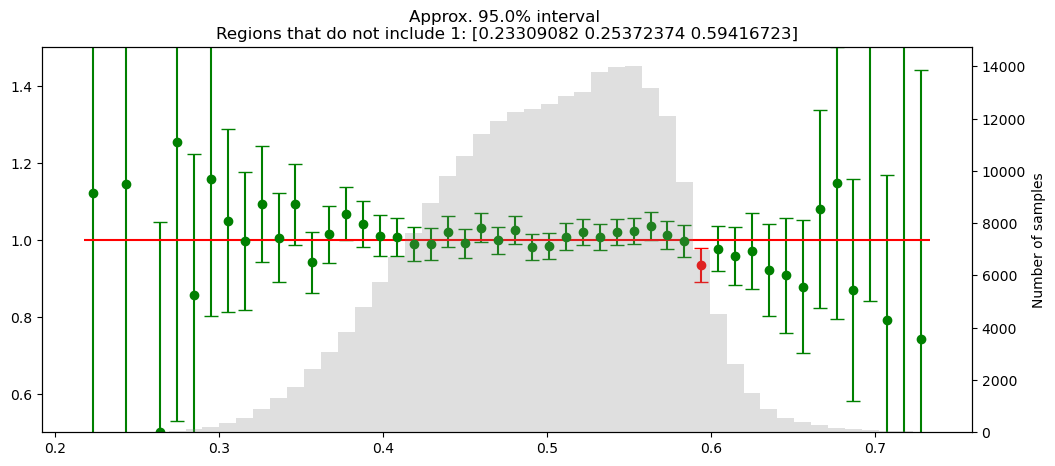

/home/soheuny/HH4bsim/playground/plots.py:226: RuntimeWarning: invalid value encountered in sqrt
  errors[i] = 1.96 * np.sqrt(


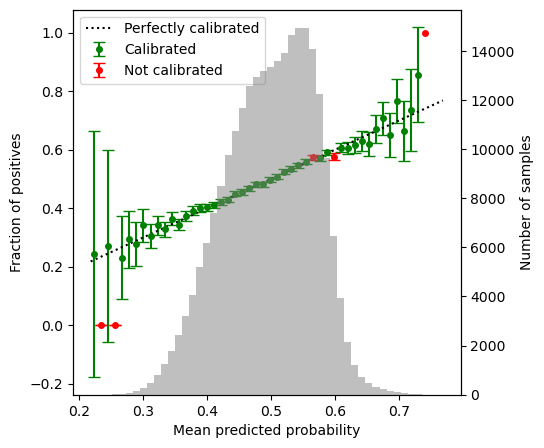

In [12]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

print("**Test Data**")


plot_prob_weighted_histogram1d(probs_4b_test, probs_4b_test, labels_4b_test,
                               n_bins=50, 
                               sample_weights=weights_test,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_test, labels_4b_test,
                 bins=50,
                 sample_weights=weights_test)

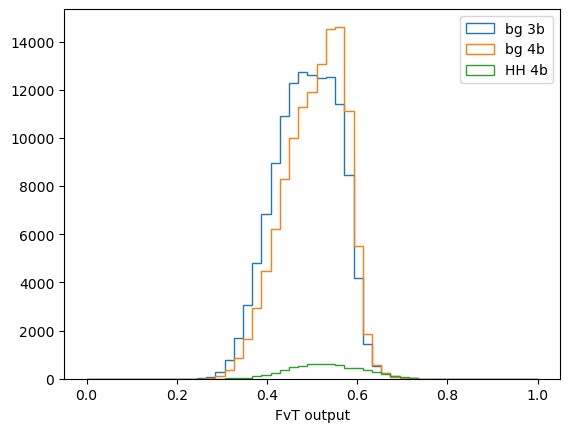

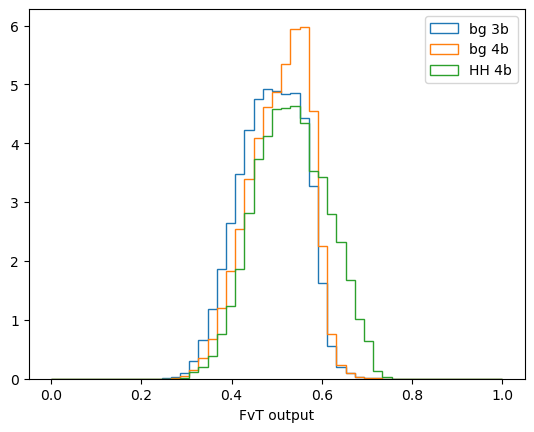

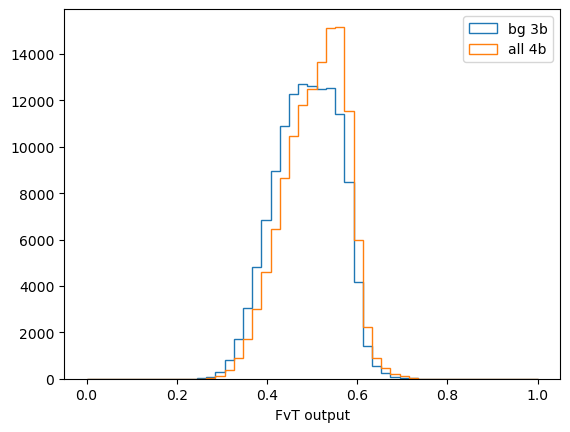

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


is_3b_test = labels_4b_test == 0
is_4b_test = labels_4b_test == 1
is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)
plot_density = True

# fig = plt.figure(figsize=(10, 3.5 * 2 * dim_quadjet_features))
# outer = gridspec.GridSpec(2*dim_quadjet_features, 3, hspace=1.5, wspace=0.3)
# for i in range(dim_quadjet_features):
#     for j in range(3):
        
#         repr_min, repr_max = np.min(q_repr_test[:, i, j]), np.max(q_repr_test[:, i, j])
#         bins_range = np.linspace(repr_min, repr_max, 50)
        
#         inner = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=outer[2*i:2*(i+1), j], hspace=0.2, height_ratios=[1, 1, 1, 1])
#         current_ax = plt.Subplot(fig, inner[0])
#         current_ax.hist(q_repr_test[is_3b_test, i, j], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=True, weights=weights_test[is_3b_test])
#         current_ax.hist(q_repr_test[is_bg4b_test, i, j], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_bg4b_test])
#         current_ax.hist(q_repr_test[is_hh4b_test, i, j], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_hh4b_test])
#         # calculate distance between two histograms (total variation distance)
#         # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
#         current_ax.set_title(f"View {j}, Feature {i}")
#         # remove x labels
#         current_ax.set_xticks([])
#         current_ax.legend()
#         fig.add_subplot(current_ax)

#         current_ax = plt.Subplot(fig, inner[1])

#         current_ax.hist(q_repr_test[is_3b_test, i, j], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
#         current_ax.hist(q_repr_test[is_bg4b_test, i, j], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_bg4b_test])
#         current_ax.hist(q_repr_test[is_hh4b_test, i, j], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_hh4b_test])
#         # calculate distance between two histograms (total variation distance)
#         # tvd = 0.5 * np.sum(np.abs(repr_hist_3b - repr_hist_4b))
#         # current_ax.set_title(f"View {j}, Feature {i}")
#         # remove x labels
#         current_ax.set_xticks([])
#         current_ax.legend()
#         fig.add_subplot(current_ax)

#         current_ax = plt.Subplot(fig, inner[2])
#         current_ax.hist(q_repr_test[is_3b_test, i, j], bins=bins_range, label="3b", linewidth=1, histtype="step", density=True, weights=weights_test[is_3b_test])
#         current_ax.hist(q_repr_test[is_4b_test, i, j], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_4b_test])
#         # calculate distance between two histograms (total variation distance)
#         # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
#         # remove x labels
#         current_ax.set_xticks([])
#         current_ax.legend()

#         fig.add_subplot(current_ax)
#         current_ax = plt.Subplot(fig, inner[3])
#         current_ax.hist(q_repr_test[is_3b_test, i, j], bins=bins_range, label="3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
#         current_ax.hist(q_repr_test[is_4b_test, i, j], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_4b_test])
#         # calculate distance between two histograms (total variation distance)
#         # current_ax.set_title(f"View {j}, Feature {i}, TV: {tvd:.2f}")
#         # remove x labels
#         current_ax.legend()
#         fig.add_subplot(current_ax)


# plt.show()
# plt.close()

bins_range = np.linspace(0, 1, 50)

fig, ax = plt.subplots()
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
ax.hist(probs_4b_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_bg4b_test])
ax.hist(probs_4b_test[is_hh4b_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_hh4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

fig, ax = plt.subplots()
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=True, weights=weights_test[is_3b_test])
ax.hist(probs_4b_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_bg4b_test])
ax.hist(probs_4b_test[is_hh4b_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_hh4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

fig, ax = plt.subplots()
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
ax.hist(probs_4b_test[is_4b_test], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()



In [14]:
# import plotly.graph_objects as go

# n_points = min(np.sum(is_3b_test), np.sum(is_bg4b_test), np.sum(is_hh4b_test))

# is_3b_plot = np.random.choice(np.where(is_3b_test)[0], n_points, replace=False)
# is_bg4b_plot = np.random.choice(np.where(is_bg4b_test)[0], n_points, replace=False)
# is_hh4b_plot = np.random.choice(np.where(is_hh4b_test)[0], n_points, replace=False)

# for i in range(dim_quadjet_features):
#     fig = go.Figure()
#     fig.update_layout(width=600, height=600)
#     fig.update_layout(title=f"Feature {i}")
#     fig.update_layout(hovermode=False)
#     fig.add_trace(go.Scatter3d
#                     (x=q_repr_test[is_3b_plot, i, 0], y=q_repr_test[is_3b_plot, i, 1], z=q_repr_test[is_3b_plot, i, 2], mode='markers', name='bg 3b', marker=dict(size=3, color="blue", opacity=0.4)))
#     fig.add_trace(go.Scatter3d
#                     (x=q_repr_test[is_bg4b_plot, i, 0], y=q_repr_test[is_bg4b_plot, i, 1], z=q_repr_test[is_bg4b_plot, i, 2], mode='markers', name='bg 4b', marker=dict(size=3, color="orange", opacity=0.4)))
#     fig.add_trace(go.Scatter3d
#                     (x=q_repr_test[is_hh4b_plot, i, 0], y=q_repr_test[is_hh4b_plot, i, 1], z=q_repr_test[is_hh4b_plot, i, 2], mode='markers', name='HH 4b', marker=dict(size=3, color="green"))
#                     )
#     fig.update_layout(scene=dict(xaxis_title=f"View 0", yaxis_title=f"View 1", zaxis_title=f"View 2"))
#     fig.show()

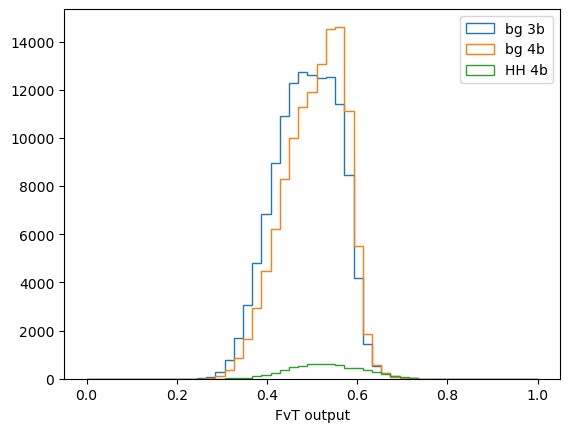

Plotting 6250 per class with prob4b > 0.0


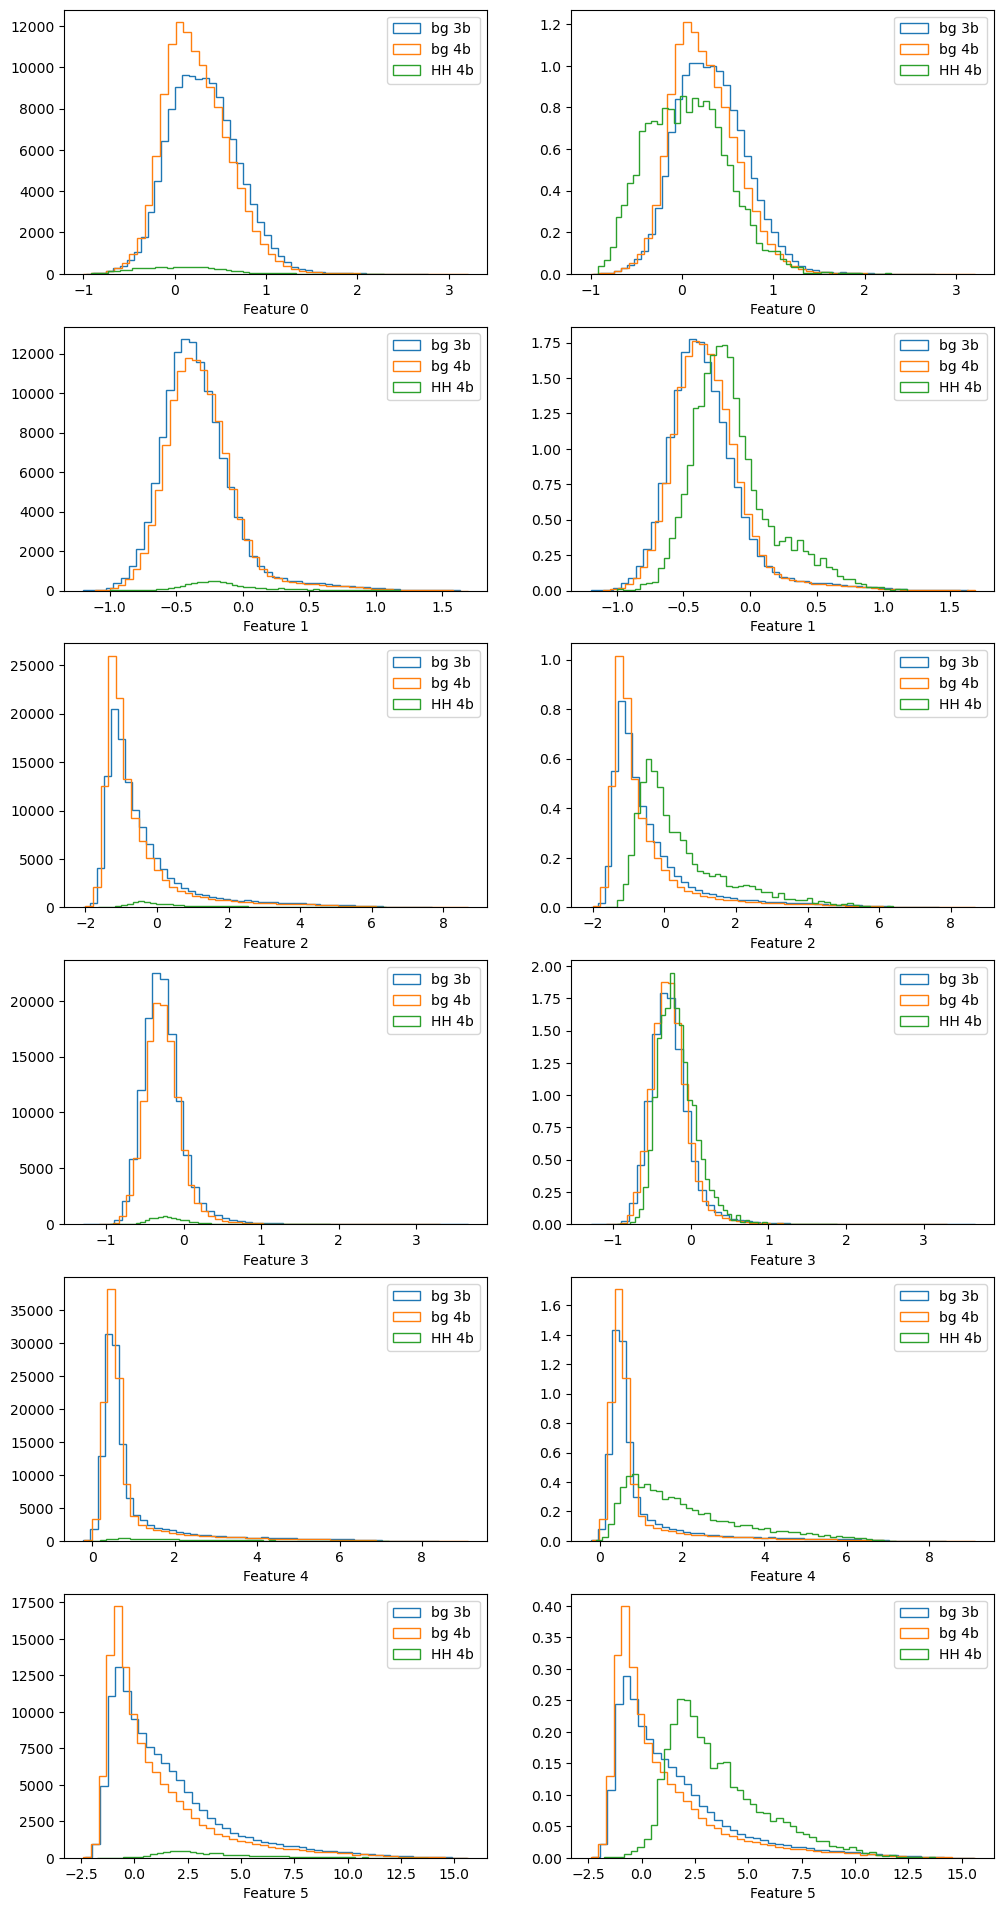

In [15]:
# Pair plots with prob4b threshold

fig, ax = plt.subplots()
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
ax.hist(probs_4b_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_bg4b_test])
ax.hist(probs_4b_test[is_hh4b_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_hh4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

probs_4b_threshold = 0.0
probs_4b_exceeded = probs_4b_test > probs_4b_threshold

n_points = min(np.sum(is_3b_test & probs_4b_exceeded), np.sum(is_bg4b_test & probs_4b_exceeded), np.sum(is_hh4b_test & probs_4b_exceeded))
print(f"Plotting {n_points} per class with prob4b > {probs_4b_threshold}")

is_3b_plot = np.random.choice(np.where(is_3b_test & probs_4b_exceeded)[0], n_points, replace=False)
is_bg4b_plot = np.random.choice(np.where(is_bg4b_test & probs_4b_exceeded)[0], n_points, replace=False)
is_hh4b_plot = np.random.choice(np.where(is_hh4b_test & probs_4b_exceeded)[0], n_points, replace=False)

# for i in range(dim_quadjet_features):
#     fig = go.Figure()
#     fig.update_layout(width=600, height=600)
#     fig.update_layout(title=f"Feature {i}")
#     fig.update_layout(hovermode=False)
#     fig.add_trace(go.Scatter3d
#                     (x=q_repr_test[is_3b_plot, i, 0], y=q_repr_test[is_3b_plot, i, 1], z=q_repr_test[is_3b_plot, i, 2], mode='markers', name='bg 3b', marker=dict(size=3, color="blue")))
#     fig.add_trace(go.Scatter3d
#                     (x=q_repr_test[is_bg4b_plot, i, 0], y=q_repr_test[is_bg4b_plot, i, 1], z=q_repr_test[is_bg4b_plot, i, 2], mode='markers', name='bg 4b', marker=dict(size=3, color="orange")))
#     fig.add_trace(go.Scatter3d
#                     (x=q_repr_test[is_hh4b_plot, i, 0], y=q_repr_test[is_hh4b_plot, i, 1], z=q_repr_test[is_hh4b_plot, i, 2], mode='markers', name='HH 4b', marker=dict(size=3, color="green"))
#                     )
#     fig.update_layout(scene=dict(xaxis_title=f"View 0", yaxis_title=f"View 1", zaxis_title=f"View 2"))
#     fig.show()

att_q_repr_test = (q_repr_test @ view_scores_test[:, :, None]).reshape(-1, dim_quadjet_features)

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 24))

for i in range(dim_quadjet_features):
    ax[i, 0].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=False, weights=weights_test[is_3b_test])
    ax[i, 0].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_bg4b_test])
    ax[i, 0].hist(att_q_repr_test[is_hh4b_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=False, weights=weights_test[is_hh4b_test])
    ax[i, 0].legend()
    ax[i, 0].set_xlabel(f"Feature {i}")
    
    ax[i, 1].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=True, weights=weights_test[is_3b_test])
    ax[i, 1].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_bg4b_test])
    ax[i, 1].hist(att_q_repr_test[is_hh4b_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=True, weights=weights_test[is_hh4b_test])
    ax[i, 1].legend()
    ax[i, 1].set_xlabel(f"Feature {i}")

plt.show()
plt.close()


In [16]:
from scipy import stats
import plotly.graph_objects as go

def plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, 
              n_components=2):
    

    assert cluster_repr_test.shape[1] == n_components

    if n_components == 1:
        # histogram
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        cluster_repr_test = cluster_repr_test.reshape(-1)
        bins_range = np.linspace(np.min(cluster_repr_test), np.max(cluster_repr_test), 50)
        hist_3b, _, _ = ax[0].hist(cluster_repr_test[is_3b_cluster], weights=weights_cluster[is_3b_cluster],
                bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False)
        hist_bg4b, _, _ = ax[0].hist(cluster_repr_test[is_bg4b_cluster], weights=weights_cluster[is_bg4b_cluster],
                bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False)
        hist_hh4b, _, _ = ax[0].hist(cluster_repr_test[is_hh4b_cluster], weights=weights_cluster[is_hh4b_cluster],
                bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False)
        ax[0].legend()
        ax[0].set_xlabel("cluster")
        # 4b / 3b ratio

        hist_4b = hist_bg4b + hist_hh4b
        ratio_mean = hist_4b / hist_3b
        ratio_std = np.sqrt(
            hist_4b * (1 / hist_3b) ** 2 + (hist_4b / hist_3b**2) ** 2
        )
        alpha = 0.05
        z = stats.norm.ppf(1 - alpha / 2)
        ratio_lb = ratio_mean.reshape(-1) - z * ratio_std.reshape(-1)
        ratio_ub = ratio_mean.reshape(-1) + z * ratio_std.reshape(-1)
        ax[1].plot(bins_range[:-1], ratio_mean, label="4b / 3b")
        ax[1].fill_between(bins_range[:-1], ratio_lb, ratio_ub, alpha=0.3)
        ax[1].legend()
        ax[1].set_xlabel("cluster")
        
        plt.show()
        plt.close()
    else:
        fig = go.Figure()
        fig.update_layout(width=600, height=600)
        fig.update_layout(hovermode=False)
        if n_components == 2:
            fig.add_trace(go.Scatter(x=cluster_repr_test[is_3b_cluster, 0], y=cluster_repr_test[is_3b_cluster, 1],
                                    mode='markers', name='bg 3b', marker=dict(size=2, color="blue")))
            fig.add_trace(go.Scatter(x=cluster_repr_test[is_bg4b_cluster, 0], y=cluster_repr_test[is_bg4b_cluster, 1],
                                    mode='markers', name='bg 4b', marker=dict(size=2, color="orange")))
            fig.add_trace(go.Scatter(x=cluster_repr_test[is_hh4b_cluster, 0], y=cluster_repr_test[is_hh4b_cluster, 1],
                                    mode='markers', name='HH 4b', marker=dict(size=3, color="green"))
                            )
        elif n_components == 3:
            fig.add_trace(go.Scatter3d(x=cluster_repr_test[is_3b_cluster, 0], y=cluster_repr_test[is_3b_cluster, 1], z=cluster_repr_test[is_3b_cluster, 2],
                                    mode='markers', name='bg 3b', marker=dict(size=2, color="blue")))
            fig.add_trace(go.Scatter3d(x=cluster_repr_test[is_bg4b_cluster, 0], y=cluster_repr_test[is_bg4b_cluster, 1], z=cluster_repr_test[is_bg4b_cluster, 2],
                                    mode='markers', name='bg 4b', marker=dict(size=2, color="orange")))
            fig.add_trace(go.Scatter3d(x=cluster_repr_test[is_hh4b_cluster, 0], y=cluster_repr_test[is_hh4b_cluster, 1], z=cluster_repr_test[is_hh4b_cluster, 2],
                                    mode='markers', name='HH 4b', marker=dict(size=3, color="green"))
                            )
        
        fig.show()

In [23]:
# umap

import umap
from sklearn.manifold import TSNE

n_components = 2
umap_reducer = umap.UMAP(n_components=n_components, random_state=seed_)
tsne_reducer = TSNE(n_components=n_components, random_state=seed_)

reducer = umap_reducer

# TSNE seems not to work well
# tsne_reducer.transform is not implemented
# reducer = tsne_reducer

# random sample of 10000 points

probs_4b_threshold = 0.6
probs_4b_exceeded = probs_4b_test > probs_4b_threshold

n_points = min(np.sum(probs_4b_exceeded), 5000)
np.random.seed(seed_)
cluster_samples = np.random.choice(np.where(probs_4b_exceeded)[0], n_points, replace=False)
# cluster_samples = np.random.choice(np.where(~probs_4b_exceeded)[0], n_points, replace=False)
# cluster_samples = np.random.choice(np.where(probs_4b_exceeded & (~is_signal_test))[0], n_points, replace=False)
q_repr_cluster = q_repr_test[cluster_samples]
is_3b_cluster = labels_4b_test[cluster_samples] == 0
is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
is_hh4b_cluster = is_signal_test[cluster_samples] == 1
weights_cluster = weights_test[cluster_samples]
view_scores_cluster = view_scores_test[cluster_samples]

# print number of points in each class
print("Thresholded samples")
print("3b: ", np.sum(is_3b_cluster))
print("bg4b: ", np.sum(is_bg4b_cluster))
print("hh4b: ", np.sum(is_hh4b_cluster))

# cluster_repr_test = umap_reducer.fit_transform(q_repr_cluster.reshape(-1, 3*dim_quadjet_features))

# plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_test = reducer.fit_transform(att_q_repr_cluster)

plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)


# failed samples
print("Failed samples")
print("3b: ", np.sum(is_3b_test & ~probs_4b_exceeded))
print("bg4b: ", np.sum(is_bg4b_test & ~probs_4b_exceeded))
print("hh4b: ", np.sum(is_hh4b_test & ~probs_4b_exceeded))

thrs_fail_samples = np.random.choice(np.where(probs_4b_test < probs_4b_threshold)[0], n_points, replace=False)
q_repr_fail = q_repr_test[thrs_fail_samples]
is_3b_fail = labels_4b_test[thrs_fail_samples] == 0
is_bg4b_fail = (labels_4b_test[thrs_fail_samples] == 1) & (is_signal_test[thrs_fail_samples] == 0)
is_hh4b_fail = is_signal_test[thrs_fail_samples] == 1
weights_fail = weights_test[thrs_fail_samples]
view_scores_fail = view_scores_test[thrs_fail_samples]

att_q_repr_fail = (q_repr_fail @ view_scores_fail[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_fail = reducer.transform(att_q_repr_fail)

plot_cluster(cluster_repr_fail, is_3b_fail, is_bg4b_fail, is_hh4b_fail, weights_fail, n_components=n_components)

Thresholded samples
3b:  1914
bg4b:  2488
hh4b:  598


/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



Failed samples
3b:  120814
bg4b:  113214
hh4b:  4889


In [24]:
# randomly choose 30000 points

random_idx = np.random.choice(att_q_repr_test.shape[0], 30000, replace=False)
umap_embed_test_sample = umap_reducer.transform(att_q_repr_test[random_idx])

plot_cluster(umap_embed_test_sample, is_3b_test[random_idx], is_bg4b_test[random_idx], is_hh4b_test[random_idx], weights_test[random_idx], n_components=n_components)

In [166]:
def signal_cluster_criteria(x):
    return x < 10

print(np.mean(signal_cluster_criteria(umap_embed_test_sample[:, 0])))
print(np.mean(signal_cluster_criteria(umap_embed_test_sample[:, 0]) & (is_signal_test[random_idx] == 1)) / np.mean(is_signal_test[random_idx] == 1))

0.6187666666666667
0.9859154929577466


In [25]:
# Count number of 4b points among 100 nearest neighbors
# Beware of cherry-picking

from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go

n_neighbors = 50
nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(cluster_repr_test)

distances, indices = nn.kneighbors(cluster_repr_test)
is_4b_cluster = labels_4b_test[cluster_samples] == 1
probs_4b_cluster = probs_4b_test[cluster_samples]
n_4b_neighbors = np.mean(is_4b_cluster[indices] == 1, axis=1)

fig = go.Figure()
# fig.update_layout(width=600, height=600)
# fig.update_layout(hovermode=False)

min_n_4b_neighbors = np.min(n_4b_neighbors)
max_n_4b_neighbors = np.max(n_4b_neighbors)
if n_components == 2:
    thresholds = np.linspace(min_n_4b_neighbors, max_n_4b_neighbors, 11)
    n_points_after_thrs = []
    min_x, max_x = np.min(cluster_repr_test[:, 0]), np.max(cluster_repr_test[:, 0])
    min_y, max_y = np.min(cluster_repr_test[:, 1]), np.max(cluster_repr_test[:, 1])
    min_n_4b_neighbors, max_n_4b_neighbors = np.min(n_4b_neighbors), np.max(n_4b_neighbors)

    for thr in thresholds:
        is_4b_thr = n_4b_neighbors > thr
        n_points_after_thrs.append(np.sum(is_4b_thr))

        fig.add_trace(go.Scatter(x=cluster_repr_test[is_4b_thr, 0], 
                                y=cluster_repr_test[is_4b_thr, 1],
                                mode='markers', marker=dict(size=3, color=n_4b_neighbors[is_4b_thr],
                                                            colorbar=dict(title="Fraction of 4b neighbors"),
                                                            cmin=min_n_4b_neighbors, cmax=max_n_4b_neighbors, 
                                                            colorscale="Viridis"),
                                visible=False,
                                name=f"Threshold: {thr:.2f}"))
        
    fig.data[0].visible = True

    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],
            label=f"{thresholds[i]:.2f} ({n_points_after_thrs[i]})",
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)
    
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Threshold: "},
        steps=steps,
    )]
    
    fig.update_layout(sliders=sliders)
    fig.update_xaxes(range=[min_x - (max_x - min_x) / 10, max_x + (max_x - min_x) / 10])
    fig.update_yaxes(range=[min_y - (max_y - min_y) / 10, max_y + (max_y - min_y) / 10])
        

elif n_components == 3:
    fig.add_trace(go.Scatter3d(x=cluster_repr_test[:, 0], 
                            y=cluster_repr_test[:, 1],
                            z=cluster_repr_test[:, 2],
                            mode='markers', marker=dict(color=n_4b_neighbors[:], 
                                                        colorbar=dict(title="Fraction of 4b neighbors"), 
                                                        colorscale="Viridis", size=3)))
fig.show()

In [ ]:
# Count number of 4b points among 100 nearest neighbors
# Beware of cherry-picking

from sklearn.neighbors import NearestNeighbors

n_neighbors = 50
nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(cluster_repr_test)

distances, indices = nn.kneighbors(cluster_repr_test)
is_4b_cluster = labels_4b_test[cluster_samples] == 1
probs_4b_cluster = probs_4b_test[cluster_samples]
n_4b_neighbors = np.mean(is_4b_cluster[indices] == 1, axis=1)

fig = go.Figure()
# fig.update_layout(width=600, height=600)
# fig.update_layout(hovermode=False)

min_n_4b_neighbors = np.min(n_4b_neighbors)
max_n_4b_neighbors = np.max(n_4b_neighbors)
if n_components == 2:
    thresholds = np.linspace(min_n_4b_neighbors, max_n_4b_neighbors, 11)
    n_points_after_thrs = []
    min_x, max_x = np.min(cluster_repr_test[:, 0]), np.max(cluster_repr_test[:, 0])
    min_y, max_y = np.min(cluster_repr_test[:, 1]), np.max(cluster_repr_test[:, 1])
    # min_n_4b_neighbors, max_n_4b_neighbors = np.min(n_4b_neighbors), np.max(n_4b_neighbors)
    min_n_4b_neighbors, max_n_4b_neighbors = np.min(probs_4b_cluster), np.max(probs_4b_cluster)

    for thr in thresholds:
        # is_4b_thr = n_4b_neighbors > thr
        is_4b_thr = probs_4b_cluster > thr
        n_points_after_thrs.append(np.sum(is_4b_thr))

        fig.add_trace(go.Scatter(x=cluster_repr_test[is_4b_thr, 0], 
                                y=cluster_repr_test[is_4b_thr, 1],
                                mode='markers', marker=dict(size=3, color=probs_4b_cluster[is_4b_thr],
                                                            colorbar=dict(title="Fraction of 4b neighbors"),
                                                            cmin=min_n_4b_neighbors, cmax=max_n_4b_neighbors, 
                                                            colorscale="Viridis"),
                                visible=False,
                                name=f"Threshold: {thr:.2f}"))
        
    fig.data[0].visible = True

    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],
            label=f"{thresholds[i]:.2f} ({n_points_after_thrs[i]})",
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)
    
    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Threshold: "},
        steps=steps,
    )]
    
    fig.update_layout(sliders=sliders)
    fig.update_xaxes(range=[min_x - (max_x - min_x) / 10, max_x + (max_x - min_x) / 10])
    fig.update_yaxes(range=[min_y - (max_y - min_y) / 10, max_y + (max_y - min_y) / 10])
        

elif n_components == 3:
    fig.add_trace(go.Scatter3d(x=cluster_repr_test[:, 0], 
                            y=cluster_repr_test[:, 1],
                            z=cluster_repr_test[:, 2],
                            mode='markers', marker=dict(color=n_4b_neighbors[:], 
                                                        colorbar=dict(title="Fraction of 4b neighbors"), 
                                                        colorscale="Viridis", size=3)))
fig.show()

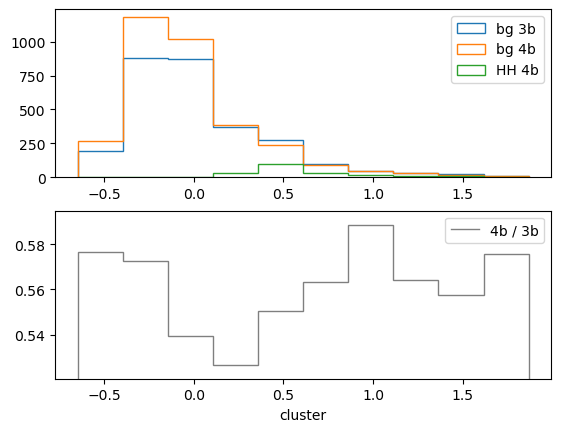

In [15]:
# kernel PCA on cluster_q_repr

from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=1, kernel="sigmoid", gamma=0.1)
cluster_repr_test_kpca = kpca.fit_transform(att_q_repr_cluster)

fig, ax = plt.subplots(ncols=1, nrows=2)

bins_range = np.linspace(np.min(cluster_repr_test_kpca), np.max(cluster_repr_test_kpca), 11)
hist_3b, _, _ = ax[0].hist(cluster_repr_test_kpca[is_3b_cluster], bins=bins_range, label="bg 3b", histtype="step", density=False, weights=weights_cluster[is_3b_cluster])
hist_bg4b, _, _ = ax[0].hist(cluster_repr_test_kpca[is_bg4b_cluster], bins=bins_range, label="bg 4b", histtype="step", density=False, weights=weights_cluster[is_bg4b_cluster])
hist_hh4b, _, _ = ax[0].hist(cluster_repr_test_kpca[is_hh4b_cluster], bins=bins_range, label="HH 4b", histtype="step", density=False, weights=weights_cluster[is_hh4b_cluster])
ax[0].legend()


hist_4b = hist_bg4b + hist_hh4b
min_h, max_h = np.min(hist_4b / (hist_4b + hist_3b)), np.max(hist_4b / (hist_4b + hist_3b))
ax[1].stairs(hist_4b / (hist_4b + hist_3b), bins_range, label="4b / 3b", alpha=0.5, color="k")
ax[1].set_xlabel("cluster")
ax[1].set_ylim(min_h - 0.1 * (max_h - min_h), max_h + 0.1 * (max_h - min_h))
ax[1].legend()

plt.show()
plt.close()